In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import copy

import skimage.io as io
from scipy.misc import bytescale

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Permute
from keras.layers import Convolution2D, Deconvolution2D, Cropping2D
from keras.layers import merge

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled)


In [3]:
from utils import fcn32_blank, prediction

## Build model architecture

### Paper 1 : Conditional Random Fields as Recurrent Neural Networks
##### Shuai Zheng, Sadeep Jayasumana, Bernardino Romera-Paredes, Vibhav Vineet, Zhizhong Su
##### Dalong Du, Chang Huang, Philip H. S. Torr

http://www.robots.ox.ac.uk/~szheng/papers/CRFasRNN.pdf

### Paper 2 : Efficient Inference in Fully Connected CRFs with Gaussian Edge Potentials
##### Philipp Krahenbuhl, Vladlen Koltun

https://arxiv.org/pdf/1210.5644.pdf

This paper specifies the CRF kernels and the Mean Field Approximation of the CRF energy function


### WARNING :
#### In v1 of this script we will only implement the FCN-8s subcomponent of the CRF-RNN network

#### Quotes from MatConvNet page (http://www.vlfeat.org/matconvnet/pretrained/#semantic-segmentation) :
*These networks are trained on the PASCAL VOC 2011 training and (in part) validation data, using Berekely's extended annotations, as well as Microsoft COCO.*

*While the CRF component is missing (it may come later to MatConvNet), this model still outperforms the FCN-8s network above, partially because it is trained with additional data from COCO.*

*The model was obtained by first fine-tuning the plain FCN-32s network (without the CRF-RNN part) on COCO data, then building built an FCN-8s network with the learnt weights, and finally training the CRF-RNN network end-to-end using VOC 2012 training data only. The model available here is the FCN-8s part of this network (without CRF-RNN, while trained with 10 iterations CRF-RNN).*

In [4]:
# WARNING : explanation about Deconvolution2D layer
# http://stackoverflow.com/questions/39018767/deconvolution2d-layer-in-keras
# the code example in the help (??Deconvolution2D) is very usefull too

#?? Deconvolution2D

In [5]:
fcn32model = fcn32_blank()

In [6]:
#fcn32model.summary() # visual inspection of model architecture

In [7]:
sp4 = Convolution2D(21, 1, 1,
                    border_mode='same', # WARNING : zero or same ? does not matter for 1x1
                    activation=None, # WARNING : to check
                    name='score_pool4')

# INFO : to replicate MatConvNet.DAGN.Sum layer see documentation at :
# https://keras.io/getting-started/sequential-model-guide/
score_fused = merge([sp4(fcn32model.layers[14].output), fcn32model.layers[-1].output], mode='sum')

s4deconv = Deconvolution2D(21, 4, 4,
                        output_shape=(None, 21, 66, 66),
                        border_mode='valid', # WARNING : valid, same or full ?
                        subsample=(2, 2),
                        activation=None,
                        name = 'score4')

crop1111 = Cropping2D(cropping=((1, 1), (1, 1))) # WARNING : cropping as deconv gained pixels

score4 = crop1111(s4deconv(score_fused))

# WARNING : check dimensions
sp3 = Convolution2D(21, 1, 1,
                    border_mode='same', # WARNING : zero or same ? does not matter for 1x1
                    activation=None, # WARNING : to check
                    name='score_pool3')

score_final = merge([sp3(fcn32model.layers[10].output), score4], mode='sum') # WARNING : is that correct ?

upsample = Deconvolution2D(21, 16, 16,
                        output_shape=(None, 21, 520, 520),
                        border_mode='valid', # WARNING : valid, same or full ?
                        subsample=(8, 8),
                        activation=None,
                        name = 'upsample')

bigscore = upsample(score_final)

crop4444 = Cropping2D(cropping=((4, 4), (4, 4))) # WARNING : cropping as deconv gained pixels

coarse = crop4444(bigscore)

fcn8model = Model(fcn32model.input, coarse)

In [8]:
# WARNING : check dim weights against .mat file to check deconvolution setting
print fcn32model.layers[-2].get_weights()[0].shape
print s4deconv.get_weights()[0].shape
print upsample.get_weights()[0].shape

(21, 21, 4, 4)
(21, 21, 4, 4)
(21, 21, 16, 16)


In [9]:
# INFO : dummy image array to test the model passes
imarr = np.ones((3,512,512))
imarr = np.expand_dims(imarr, axis=0)

#testmdl = Model(fcn32model.input, fcn32model.layers[10].output) # works fine
#testmdl = Model(fcn32model.input, score4) # works fine
#testmdl = Model(fcn32model.input, sp3(fcn32model.layers[10].output)) # works fine
#testmdl = Model(fcn32model.input, score_final) # works fine
#testmdl = Model(fcn32model.input, bigscore)
testmdl = fcn8model
testmdl.predict(imarr).shape

(1, 21, 512, 512)

In [10]:
fcn8model.summary() # visual inspection of model architecture

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_input_1 (InputLayer)     (None, 3, 512, 512)   0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 3, 512, 512)   0           permute_input_1[0][0]            
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 512, 512)  1792        permute_1[0][0]                  
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 512, 512)  36928       conv1_1[0][0]                    
___________________________________________________________________________________________

## Load VGG weigths from .mat file

#### https://www.vlfeat.org/matconvnet/pretrained/#semantic-segmentation
##### Download from console with :
wget http://www.vlfeat.org/matconvnet/models/pascal-fcn8s-tvg-dag.mat

In [11]:
from scipy.io import loadmat

In [12]:
# WARNING : weights from file pascal-fcn8s-dag.mat should reflect the same architecture
data = loadmat('pascal-fcn8s-tvg-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description

In [13]:
l.shape, p.shape, description.shape

((1, 46), (1, 40), (1, 21))

In [14]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [15]:
if False: # inspection of data structure
    print(dir(l[0,31].block[0,0]))
    print(dir(l[0,44].block[0,0]))

if False:
    print l[0,36].block[0,0].upsample, l[0,36].block[0,0].size
    print l[0,40].block[0,0].upsample, l[0,40].block[0,0].size
    print l[0,44].block[0,0].upsample, l[0,44].block[0,0].size, l[0,44].block[0,0].crop

In [16]:
for i in range(0, p.shape[1]-1-2*2, 2): # weights #36 to #37 are not all paired
    print(i,
          str(p[0,i].name[0]), p[0,i].value.shape,
          str(p[0,i+1].name[0]), p[0,i+1].value.shape)
print '------------------------------------------------------'
for i in range(p.shape[1]-1-2*2+1, p.shape[1]): # weights #36 to #37 are not all paired
    print(i,
          str(p[0,i].name[0]), p[0,i].value.shape)

(0, 'conv1_1f', (3, 3, 3, 64), 'conv1_1b', (64, 1))
(2, 'conv1_2f', (3, 3, 64, 64), 'conv1_2b', (64, 1))
(4, 'conv2_1f', (3, 3, 64, 128), 'conv2_1b', (128, 1))
(6, 'conv2_2f', (3, 3, 128, 128), 'conv2_2b', (128, 1))
(8, 'conv3_1f', (3, 3, 128, 256), 'conv3_1b', (256, 1))
(10, 'conv3_2f', (3, 3, 256, 256), 'conv3_2b', (256, 1))
(12, 'conv3_3f', (3, 3, 256, 256), 'conv3_3b', (256, 1))
(14, 'conv4_1f', (3, 3, 256, 512), 'conv4_1b', (512, 1))
(16, 'conv4_2f', (3, 3, 512, 512), 'conv4_2b', (512, 1))
(18, 'conv4_3f', (3, 3, 512, 512), 'conv4_3b', (512, 1))
(20, 'conv5_1f', (3, 3, 512, 512), 'conv5_1b', (512, 1))
(22, 'conv5_2f', (3, 3, 512, 512), 'conv5_2b', (512, 1))
(24, 'conv5_3f', (3, 3, 512, 512), 'conv5_3b', (512, 1))
(26, 'fc6f', (7, 7, 512, 4096), 'fc6b', (4096, 1))
(28, 'fc7f', (1, 1, 4096, 4096), 'fc7b', (4096, 1))
(30, 'score_frf', (1, 1, 4096, 21), 'score_frb', (21, 1))
(32, 'score2f', (4, 4, 21, 21), 'score2b', (21, 1))
(34, 'score_pool4f', (1, 1, 512, 21), 'score_pool4b', (21, 

In [17]:
for i in range(l.shape[1]):
    print(i,
          str(l[0,i].name[0]), str(l[0,i].type[0]),
          [str(n[0]) for n in l[0,i].inputs[0,:]],
          [str(n[0]) for n in l[0,i].outputs[0,:]])

(0, 'conv1_1', 'dagnn.Conv', ['data'], ['conv1_1'])
(1, 'relu1_1', 'dagnn.ReLU', ['conv1_1'], ['conv1_1x'])
(2, 'conv1_2', 'dagnn.Conv', ['conv1_1x'], ['conv1_2'])
(3, 'relu1_2', 'dagnn.ReLU', ['conv1_2'], ['conv1_2x'])
(4, 'pool1', 'dagnn.Pooling', ['conv1_2x'], ['pool1'])
(5, 'conv2_1', 'dagnn.Conv', ['pool1'], ['conv2_1'])
(6, 'relu2_1', 'dagnn.ReLU', ['conv2_1'], ['conv2_1x'])
(7, 'conv2_2', 'dagnn.Conv', ['conv2_1x'], ['conv2_2'])
(8, 'relu2_2', 'dagnn.ReLU', ['conv2_2'], ['conv2_2x'])
(9, 'pool2', 'dagnn.Pooling', ['conv2_2x'], ['pool2'])
(10, 'conv3_1', 'dagnn.Conv', ['pool2'], ['conv3_1'])
(11, 'relu3_1', 'dagnn.ReLU', ['conv3_1'], ['conv3_1x'])
(12, 'conv3_2', 'dagnn.Conv', ['conv3_1x'], ['conv3_2'])
(13, 'relu3_2', 'dagnn.ReLU', ['conv3_2'], ['conv3_2x'])
(14, 'conv3_3', 'dagnn.Conv', ['conv3_2x'], ['conv3_3'])
(15, 'relu3_3', 'dagnn.ReLU', ['conv3_3'], ['conv3_3x'])
(16, 'pool3', 'dagnn.Pooling', ['conv3_3x'], ['pool3'])
(17, 'conv4_1', 'dagnn.Conv', ['pool3'], ['conv4_1'])


In [18]:
# documentation for the dagnn.Crop layer :
# https://github.com/vlfeat/matconvnet/blob/master/matlab/%2Bdagnn/Crop.m

In [19]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (3,2,0,1) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, p.shape[1]):
        matname = p[0,i].name[0][0:-1]
        matname_type = p[0,i].name[0][-1] # "f" for filter weights or "b" for bias
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print 'found : ', (str(matname), str(matname_type), kindex)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            if  matname_type == 'f':
                l_weights = p[0,i].value
                f_l_weights = l_weights.transpose(prmt)
                f_l_weights = np.flip(f_l_weights, 2)
                f_l_weights = np.flip(f_l_weights, 3)
                assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
                current_b = kmodel.layers[kindex].get_weights()[1]
                kmodel.layers[kindex].set_weights([f_l_weights, current_b])
            elif  matname_type == 'b':
                l_bias = p[0,i].value
                assert (l_bias.shape[1] == 1)
                assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
                current_f = kmodel.layers[kindex].get_weights()[0]
                kmodel.layers[kindex].set_weights([current_f, l_bias[:,0]])
        else:
            print 'not found : ', str(matname)

In [20]:
#copy_mat_to_keras(fcn32model)
copy_mat_to_keras(fcn8model)

found :  ('conv1_1', 'f', 2)
found :  ('conv1_1', 'b', 2)
found :  ('conv1_2', 'f', 3)
found :  ('conv1_2', 'b', 3)
found :  ('conv2_1', 'f', 5)
found :  ('conv2_1', 'b', 5)
found :  ('conv2_2', 'f', 6)
found :  ('conv2_2', 'b', 6)
found :  ('conv3_1', 'f', 8)
found :  ('conv3_1', 'b', 8)
found :  ('conv3_2', 'f', 9)
found :  ('conv3_2', 'b', 9)
found :  ('conv3_3', 'f', 10)
found :  ('conv3_3', 'b', 10)
found :  ('conv4_1', 'f', 12)
found :  ('conv4_1', 'b', 12)
found :  ('conv4_2', 'f', 13)
found :  ('conv4_2', 'b', 13)
found :  ('conv4_3', 'f', 14)
found :  ('conv4_3', 'b', 14)
found :  ('conv5_1', 'f', 16)
found :  ('conv5_1', 'b', 16)
found :  ('conv5_2', 'f', 17)
found :  ('conv5_2', 'b', 17)
found :  ('conv5_3', 'f', 18)
found :  ('conv5_3', 'b', 18)
found :  ('fc6', 'f', 20)
found :  ('fc6', 'b', 20)
found :  ('fc7', 'f', 21)
found :  ('fc7', 'b', 21)
found :  ('score_fr', 'f', 22)
found :  ('score_fr', 'b', 22)
found :  ('score2', 'f', 23)
found :  ('score2', 'b', 23)
found : 

## Tests

In [21]:
im = Image.open('rgb.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))

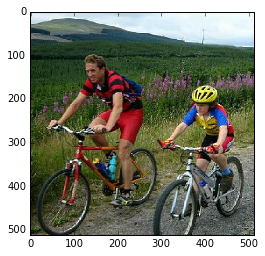

In [22]:
plt.imshow(np.asarray(im))

In [24]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit
preds = prediction(fcn8model, crpim, transform=True)

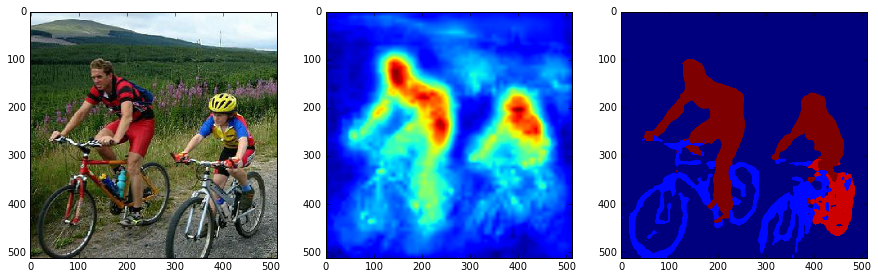

In [25]:
imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imperson )
plt.subplot(1,3,3)
plt.imshow( imclass )

In [26]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print c, str(description[0,c][0])

0 background
2 bicycle
14 motorbike
15 person


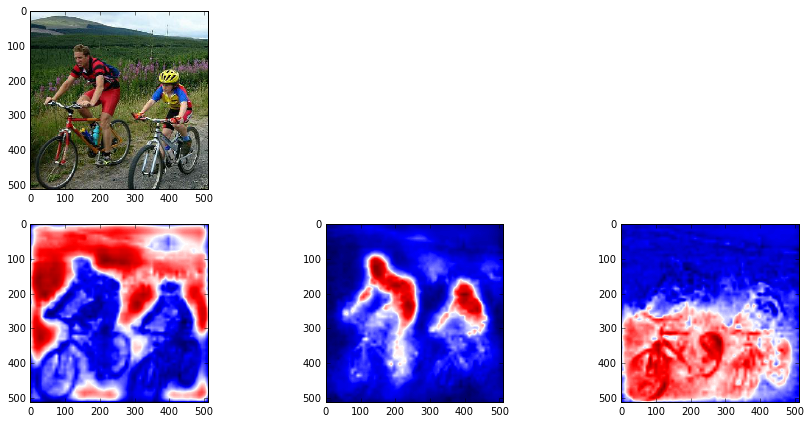

In [27]:
bspreds = bytescale(preds, low=0, high=255)

plt.figure(figsize = (15, 7))
plt.subplot(2,3,1)
plt.imshow(np.asarray(crpim))
plt.subplot(2,3,3+1)
plt.imshow(bspreds[0,class2index['background'],:,:], cmap='seismic')
plt.subplot(2,3,3+2)
plt.imshow(bspreds[0,class2index['person'],:,:], cmap='seismic')
plt.subplot(2,3,3+3)
plt.imshow(bspreds[0,class2index['bicycle'],:,:], cmap='seismic')